<a href="https://colab.research.google.com/github/samiNCL/ML/blob/main/SamiDay3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

files.upload()



{}

In [20]:
import numpy as np
import scipy.io


data = scipy.io.loadmat('PAMAP2.mat')
Xy_train0 = data['Xy_train']
Xy_test0 = data['Xy_test']


In [21]:
print('optional: channel-wise normalisation')
mn = np.mean(Xy_train0[:,:-1], axis=0)
std = np.std(Xy_train0[:,:-1], axis=0)
Xy_train0[:,:-1] = (Xy_train0[:,:-1]-mn)/std
Xy_test0[:,:-1] = (Xy_test0[:,:-1]-mn)/std


optional: channel-wise normalisation


In [22]:
cNum=12  #in this dataset, therer are 12 activities
win_len = 100
dim = Xy_train0.shape[1]-1 #minus the label col
print(dim)


27


In [23]:
def sliding_window(Xy, percentage=0.5, win_len=100):
    #print('per')
    print('overlapping_percentage:  '+str(percentage*100)+'%')

    batch_size0 = int(np.floor(len(Xy)/win_len))
    #print(batch_size0)
    Xy0 = Xy[:win_len*batch_size0,:]
    if percentage==1:
        print('100% overlapping means no overlapping')
        return Xy0

    K_fold = int(1/(1-percentage))
    #print(K_fold)
    offset = int(np.round(win_len * (1-percentage)))
    Xy_big = []
    for k in range(K_fold):
        #print(k)
        current_set = Xy0[k*offset:len(Xy0)-(win_len-k*offset),:]
        #print(len(current_set))
        Xy_big.append(current_set)
    return np.concatenate(Xy_big)

def _to_frames(Xy, dim, win_len=100):
    X3D = np.reshape(Xy[:,:-1], (-1, win_len, dim))
    y2D = np.reshape(Xy[:,-1],(-1, win_len)).astype(int)
    y = np.zeros(len(y2D))
    for i in range(len(y2D)):
        counts = np.bincount(np.reshape(y2D[i, :], (-1)))
        y[i] = np.argmax(counts)
    return X3D, y


In [24]:
print('original training data shape', Xy_train0.shape)
Xy_train = sliding_window(Xy_train0, 0.5, win_len)
print('after overlapping sliding window', Xy_train.shape)
X_train0, y_train0 = _to_frames(Xy_train,dim, win_len)
print('converting to frames (100 samples per window) with size', X_train0.shape)


#print(Xy_test0.shape)
Xy_test = sliding_window(Xy_test0, 0.5, win_len)
#print(Xy_test.shape)
X_test0, y_test0 = _to_frames(Xy_test,dim,win_len)


original training data shape (473445, 28)
overlapping_percentage:  50.0%
after overlapping sliding window (946600, 28)
converting to frames (100 samples per window) with size (9466, 100, 27)
overlapping_percentage:  50.0%


In [25]:
def building_balanced_DB(X, y, cNum, sample_number):
    print('each class will have the same sample number')
    X_new = np.empty([0, win_len, dim])
    y_new = np.empty([0])
    for i in range(cNum):
        if len(X[y==i])<sample_number:
            print('Error: not enough samples for class '+str(i) +'please choose a smaller number')
            break
        else:
            X_new = np.concatenate((X_new, X[y==i][:sample_number]), axis=0)
            #print(X_new.shape)
        
        y_new = np.concatenate((y_new, y[y==i][:sample_number]), axis=0)
        #print(y_new)
    return X_new, y_new


In [26]:
print('now it is the balanced data')
size_per_class_train = 250
size_per_class_test = 50
X_train0, y_train0 = building_balanced_DB(X_train0, y_train0, cNum, size_per_class_train)
X_test0, y_test0 = building_balanced_DB(X_test0, y_test0, cNum, size_per_class_test)


now it is the balanced data
each class will have the same sample number
each class will have the same sample number


----------train_Data---------------
class 0, sample number 250, percentage 8.3%
class 1, sample number 250, percentage 8.3%
class 2, sample number 250, percentage 8.3%
class 3, sample number 250, percentage 8.3%
class 4, sample number 250, percentage 8.3%
class 5, sample number 250, percentage 8.3%
class 6, sample number 250, percentage 8.3%
class 7, sample number 250, percentage 8.3%
class 8, sample number 250, percentage 8.3%
class 9, sample number 250, percentage 8.3%
class 10, sample number 250, percentage 8.3%
class 11, sample number 250, percentage 8.3%


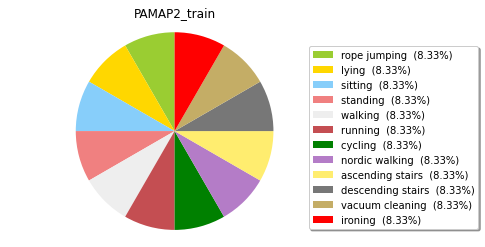

----------testing_Data--------------
class 0, sample number 50, percentage 8.3%
class 1, sample number 50, percentage 8.3%
class 2, sample number 50, percentage 8.3%
class 3, sample number 50, percentage 8.3%
class 4, sample number 50, percentage 8.3%
class 5, sample number 50, percentage 8.3%
class 6, sample number 50, percentage 8.3%
class 7, sample number 50, percentage 8.3%
class 8, sample number 50, percentage 8.3%
class 9, sample number 50, percentage 8.3%
class 10, sample number 50, percentage 8.3%
class 11, sample number 50, percentage 8.3%


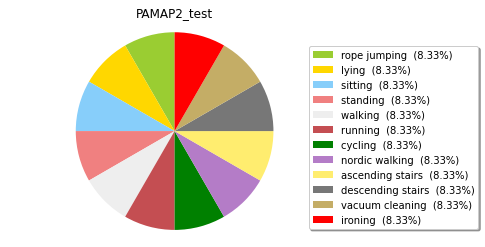

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
def drawing_pie_chart(percentages, labels, dataset_id):
    plt.title(dataset_id)
    color_set = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral',
            '#eeeeee','#C44E52', 'green', '#B47CC7','#ffed6f','#777777','#C4AD66','red', 
                  'blue',  'cyan', 'magenta',
                '#FBC15E','#56B4E9','#4878CF','#FFFEA3' ]
    
    labels = labels.copy()
    for i in range(len(percentages)):
        labels[i] = labels[i]+'  ('+str(percentages[i])[:4]+'%)'
    colors = color_set[:len(percentages)]
    
    
    patches, texts = plt.pie(percentages, colors=colors, startangle=90)
    
    plt.axis('equal')
    lgd = plt.legend(labels, loc=(0.9, 0.05), shadow=True, borderaxespad=10.)
    
    
    #plt.savefig('dataset_'+dataset_id+'.eps', bbox_extra_artists=(lgd,), bbox_inches='tight', format='eps', dpi=600)
    plt.show()
    
def calculating_percentages(y_, cNum):
    percentages = np.zeros(cNum)
    for i in range(cNum):
        num = np.sum(y_==i)
        percentages[i]=100.0*num/len(y_)
        print('class {}, sample number {}, percentage {:.1f}%'.format(i, num, percentages[i]))
    return percentages


dataset_id = 'PAMAP2'
labels_PAMAP2 = [r'rope jumping', 
                 r'lying', 
                 r'sitting', 
                 r'standing',
                 r'walking', 
                 r'running', 
                 r'cycling', 
                 r'nordic walking',
                 r'ascending stairs', 
                 r'descending stairs', 
                 r'vacuum cleaning', 
                 r'ironing']
cNum = 12 # 12 classes for PAMAP2

print('----------train_Data---------------')
percentages_train = calculating_percentages(y_train0, cNum)
drawing_pie_chart(percentages_train,labels_PAMAP2,dataset_id+'_train')

print('----------testing_Data--------------')
percentages_test = calculating_percentages(y_test0, cNum)
drawing_pie_chart(percentages_test,labels_PAMAP2,dataset_id+'_test')


**Above was data preparation. Next HAR on raw data.**

In [28]:
print('original dimension:', X_train0.shape)
X_train = np.reshape(X_train0, (-1, dim*win_len))
X_test = np.reshape(X_test0, (-1, dim*win_len))
print('reshaped dimension:', X_train.shape)

y_train = y_train0.copy()
y_test = y_test0.copy()


original dimension: (3000, 100, 27)
reshaped dimension: (3000, 2700)


In [29]:
print('original dimension:', X_train0.shape)
X_train = np.reshape(X_train0, (-1, dim*win_len))
X_test = np.reshape(X_test0, (-1, dim*win_len))
print('reshaped dimension:', X_train.shape)

y_train = y_train0.copy()
y_test = y_test0.copy()


original dimension: (3000, 100, 27)
reshaped dimension: (3000, 2700)


In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('feature scaling done!')


feature scaling done!


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


from time import time
name = ' logistic_regression_classifier '
default_C = 1

t0 = time()
clf = LogisticRegression(penalty='l2',C = default_C, max_iter=1000)
clf.fit(X_train, y_train)
print('training'+name+'takes {:.2f} seconds'.format(time()-t0))


y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('classification accuracy: {:.2f}'.format(acc))
print('random  guess  accuracy: {:.2f}'.format(1/cNum))


training logistic_regression_classifier takes 114.88 seconds
classification accuracy: 0.36
random  guess  accuracy: 0.08


In [32]:
from sklearn.svm import SVC

t0 = time()
name = ' linear_SVM '



clf = SVC(kernel="linear", C=default_C)




clf.fit(X_train, y_train)
print(name+'training takes {:.2f} seconds'.format(time()-t0))
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(name+'classification accuracy: {:.2f}'.format(acc))


 linear_SVM training takes 19.88 seconds
 linear_SVM classification accuracy: 0.34


In [33]:
t0 = time()
name = ' rbf_SVM '



clf = SVC(kernel="rbf", C=default_C)




clf.fit(X_train, y_train)
print(name+'training takes {:.2f} seconds'.format(time()-t0))
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(name+'classification accuracy: {:.2f}'.format(acc))


 rbf_SVM training takes 33.03 seconds
 rbf_SVM classification accuracy: 0.77


In [34]:
from sklearn.tree import DecisionTreeClassifier
t0 = time()
name = ' Decision Tree '


clf = DecisionTreeClassifier()



clf.fit(X_train, y_train)
print(name+'training takes {:.2f} seconds'.format(time()-t0))
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(name+'classification accuracy: {:.2f}'.format(acc))


 Decision Tree training takes 10.57 seconds
 Decision Tree classification accuracy: 0.25


In [35]:
from sklearn.ensemble import RandomForestClassifier
t0 = time()
name = ' Random forest '



clf = RandomForestClassifier(n_estimators=100)



clf.fit(X_train, y_train)
print(name+'training takes {:.2f} seconds'.format(time()-t0))
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(name+'classification accuracy: {:.2f}'.format(acc))


 Random forest training takes 13.27 seconds
 Random forest classification accuracy: 0.33


In [36]:
from sklearn.neighbors import KNeighborsClassifier
t0 = time()
name = ' KNN '

clf = KNeighborsClassifier(5)



clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(name+'classification accuracy: {:.2f}'.format(acc))
print(name+' takes {:.2f} seconds'.format(time()-t0))


 KNN classification accuracy: 0.48
 KNN  takes 11.89 seconds


In [ ]:
#Next feature eng

In [37]:
from scipy.stats import kurtosis, skew, iqr #, median_abs_deviation 
def _FE(X):
    X_mean = np.mean(X, axis=1)
    X_std = np.std(X, axis=1)
    X_var = np.var(X, axis=1)
    X_energy = np.sqrt(np.mean(np.power(X, 2), axis=1))
    X_mad= np.mean(np.abs(X - np.expand_dims(X_mean, axis=1)), axis=1)
    #X_mad1 = median_abs_deviation(X, axis=1)
    X_kurtosis = kurtosis(X, axis = 1)
    X_skew = skew(X, axis = 1)
    X_iqr = iqr(X, axis = 1)
    X_max = np.amax(X, axis=1)
    X_min = np.amin(X, axis=1)
    
    return np.concatenate((X_mean 
                           ,X_std
                           ,X_var
                           ,X_energy
                           ,X_mad
                          # ,X_mad1
                           ,X_kurtosis
                           ,X_skew
                           ,X_iqr
                           ,X_max
                           ,X_min
                          ), axis=1)



#print('performing feature engineering')
X_train = _FE(X_train0)
X_test = _FE(X_test0)
print('new feature dimension: '+str(X_train.shape[1]))
y_train = y_train0.copy()
y_test = y_test0.copy()


new feature dimension: 270


**Feature engineering bellow rather than working on raw data**

In [38]:
print('performing feature-wise normalisation!')
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


performing feature-wise normalisation!


In [39]:
from sklearn.model_selection import GridSearchCV


print('cross validation...')
parameters = [{'C': [0.05, 0.1, 0.5, 1, 5, 10]}]
print('Grid Search for best hyper-parameters...')
clf = GridSearchCV(LogisticRegression(penalty='l2', max_iter=1000), parameters, cv = 5)
clf.fit(X_train, y_train)

print('best hyper-parameters:')
print(clf.best_params_)
print('-------------------------------------')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std, params))



cross validation...
Grid Search for best hyper-parameters...
best hyper-parameters:
{'C': 0.05}
-------------------------------------
0.900 (+/-0.046) for {'C': 0.05}
0.898 (+/-0.042) for {'C': 0.1}
0.885 (+/-0.044) for {'C': 0.5}
0.881 (+/-0.042) for {'C': 1}
0.874 (+/-0.043) for {'C': 5}
0.871 (+/-0.043) for {'C': 10}


In [40]:
from sklearn.model_selection import GridSearchCV


print('cross validation...')
parameters = [{'C': [0.05, 0.1, 0.5, 1, 5, 10]}]
print('Grid Search for best hyper-parameters...')
clf = GridSearchCV(LogisticRegression(penalty='l2', max_iter=1000), parameters, cv = 5)
clf.fit(X_train, y_train)

print('best hyper-parameters:')
print(clf.best_params_)
print('-------------------------------------')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std, params))


cross validation...
Grid Search for best hyper-parameters...
best hyper-parameters:
{'C': 0.05}
-------------------------------------
0.900 (+/-0.046) for {'C': 0.05}
0.898 (+/-0.042) for {'C': 0.1}
0.885 (+/-0.044) for {'C': 0.5}
0.881 (+/-0.042) for {'C': 1}
0.874 (+/-0.043) for {'C': 5}
0.871 (+/-0.043) for {'C': 10}


In [41]:
name = 'logistic regression'
print('now with the optimal hyper-parameter C')
Optimal_C = 0.05

clf = LogisticRegression(penalty='l2',C = Optimal_C, max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(name+'classification accuracy: {:.2f}'.format(acc))


now with the optimal hyper-parameter C
logistic regressionclassification accuracy: 0.85
